In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from Datathon.Utils.apache2Calc import *
from Datathon.Utils.getData import *
from Datathon.Utils.pipeFunctions import *

from sklearn.pipeline import Pipeline

from category_encoders import TargetEncoder , HelmertEncoder , JamesSteinEncoder,MEstimateEncoder
from category_encoders.woe import WOEEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from pyod.models.knn import KNN

from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import KernelPCA , TruncatedSVD

import numpy as np

In [2]:
class RemoveOutliers():

    def __init__(self):
        self.estimator = KNN()

    def _remove(self,X):
        preds = self.estimator.predict(X)
        return X[preds , :]

    def fit(self,X,y=None):
        self.estimator.fit(X)
        return self

    def transform(self,X,y=None):
        return self._remove(X)

In [3]:
adf = getTrainingData()
#adf = adf.dropna(thresh=adf.shape[0]*0.7 , axis=1)

cols_useless =[ "encounter_id", "hospital_id","patient_id" , "icu_id" , "gender" , "ethnicity"]
#adf = adf.drop(cols_useless,  axis=1)

#cat_cols = [c for c in getCategorialColumns(adf) if c not in cols_useless + ["hospital_death"]]
def tooManyMissing(adf):
    tdf = adf.dropna(thresh=adf.shape[0]*0.75 , axis=1)
    return list(set(adf.columns).difference(set(tdf.columns)))

tooManyMissing_cols = []#tooManyMissing(adf)

cat_cols = [c for c in getCategorialColumns(adf) if c not in ["hospital_death"] + tooManyMissing_cols]
num_cols = [c for c in getNumericColumns(adf) if c not in tooManyMissing_cols]
DEPENDENT_VARIABLE = getDependentVariable()

In [4]:
len(num_cols)

156

In [5]:

numeric_cols_pipe = Pipeline(steps=[
    ('mean impute' ,SimpleImputer(strategy="mean") )
    ,('Standard Scale' ,StandardScaler() )
    ,('Kernel PCA' , TruncatedSVD(n_components=100))
])


cat_cols_pipe = Pipeline(steps=[
    ('Drop Useless' ,
        ColumnTransformer([
            ('Drop Useless Categorical Features' ,'drop' ,cols_useless )
        ],remainder='passthrough')
    )
    ,('Most Frequent impute' ,SimpleImputer(strategy="most_frequent"))
    ,('Encoding' , HelmertEncoder())
])

transform_pipe = Pipeline(steps=[
     ('Column Transform' ,
        ColumnTransformer([
            ('Drop Too Many Missing' , 'drop' , tooManyMissing_cols)
            ,('Cat Cols Pipe' ,cat_cols_pipe ,cat_cols )
            ,('Numeric Cols Pipe' ,numeric_cols_pipe ,num_cols )
        ])
    )
    #,('Drop Outlier Rows' ,RemoveOutliers())
    #,('Scale Everything' , StandardScaler())
    

])

In [6]:
X = adf.drop([DEPENDENT_VARIABLE] , axis=1)
y = adf[DEPENDENT_VARIABLE]

In [7]:
trX = transform_pipe.fit_transform(X,y)

In [8]:
trX.shape

(91713, 164)

In [11]:
import lightgbm as lgb

params ={'n_estimators':1000,
                    'boosting_type': 'gbdt',
                    'objective': 'binary',
                    'metric': 'auc',
                    'subsample': 0.75,
                    'learning_rate': 0.1,
                    'feature_fraction': 0.7,
                    'max_depth': 15,
                    'lambda_l1': 200,
                    'lambda_l2': 100,
                    "class_weight":{0:1 , 1:200},
                    #'is_unbalance' : True ,
                    'scale_pos_weight' : 3
                    ,"n_jobs":2
                    }

param_grid = {'n_estimators':1000,
                    'boosting_type': ['gbdt', 'goss'],
                    'objective': 'binary',
                    'metric': 'auc',
                    'subsample': np.linspace(0.5, 0.9 , 5),
                    'learning_rate': 0.1,
                    'feature_fraction': np.linspace(0.5, 0.9 , 5),
                    'max_depth': np.linspace(10, 20 , 5),
                    'lambda_l1': 200,
                    'lambda_l2': 100,
                    "class_weight":{0:1 , 1:200},
                    #'is_unbalance' : True ,
                    'scale_pos_weight' : 3
                    ,"n_jobs":2
                    }


lgclf = lgb.LGBMClassifier(**params)

In [12]:
watevclf = lgclf

In [13]:
from plotnine import *
from sklearn.model_selection import learning_curve


train_sizes, train_scores, valid_scores = learning_curve(watevclf, trX, y,scoring="roc_auc", train_sizes=np.linspace(0.1, 1.0, 10), cv=5 , n_jobs=-1)

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


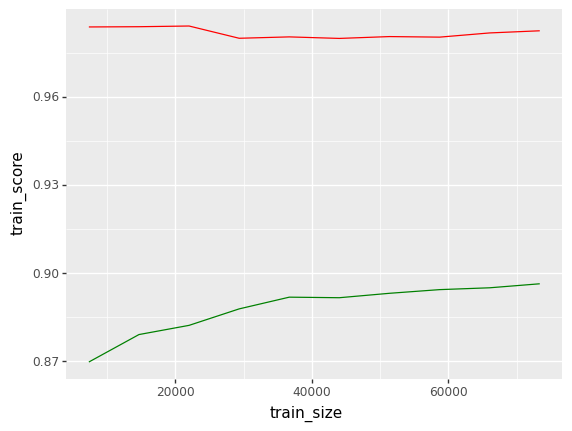

<ggplot: (8776203866265)>

In [14]:
lcurveplotdf = pd.DataFrame({"train_size":train_sizes , "train_score" : train_scores[:,1] , "valid_score":valid_scores[:,1]})

ggplot(lcurveplotdf ) + \
    geom_line(aes(x="train_size" , y="train_score") , color="red") + \
    geom_line(aes(x="train_size" , y="valid_score") , color="green")

In [15]:
lgclf.fit(trX,y)
testdf = getUnlabledData()

Xtb = testdf.drop([DEPENDENT_VARIABLE] , axis=1)
ytb = testdf[DEPENDENT_VARIABLE]

testX = transform_pipe.transform(Xtb)

testX.shape
preds = lgclf.predict_proba(testX)

saveKeraspreds  =preds[:,1]
results = pd.DataFrame({"encounter_id" : testdf['encounter_id'] , "hospital_death" :preds[:,1] })
results.to_csv("./submission.csv" , index=False)


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators':[1000],
                    'boosting_type': ['gbdt', 'goss'],
                    'objective': ['binary'],
                    'metric': ['auc'],
                    'subsample': np.linspace(0.5, 0.9 , 5),
                    'learning_rate': [0.1 , 0.01 , 1],
                    'feature_fraction': np.linspace(0.5, 0.9 , 5),
                    'max_depth': [int(i) for i in np.linspace(10, 20 , 5)],
                    'lambda_l1': [0.1 , 1, 10,20],
                    'lambda_l2': [0.1 , 1, 10,20],
                    "class_weight":[{0:1 , 1:200}]
                    #'is_unbalance' : True ,
                    #'scale_pos_weight' : 3
                    }


lgclf = lgb.LGBMClassifier(**params)

gs = GridSearchCV(lgclf , param_grid , n_jobs=-1,scoring="roc_auc" , cv = 2 , verbose=10)
gs.fit(trX , y)

Fitting 2 folds for each of 12000 candidates, totalling 24000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 25.3min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 26.2min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 27.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 29.1min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 33.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 38